# APIs

In [6]:
import shutil
import os

for path in ['cache_dir/', '__pycache__/', 'custom_transformers/__pycache__/']:
    if os.path.exists(path):
        shutil.rmtree(path)

from joblib import Memory
memory = Memory(location='cache_dir', verbose=0)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, skew, zscore
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, learning_curve, LearningCurveDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor

# %pip install lightgbm
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

from xgboost import XGBRegressor
# %pip install xgboost

from preprocessing_functions import convert_to_str, log_transform, exp_transform
from custom_transformers import EngineSizeTransformer, MultiLabelBinarizerTransformer, \
YearTransformer, KilometersTransformer, BatteryCapacityTransformer, BatteryRangeTransformer, \
LuxuryCarFlagger

import pickling_checker

# %pip install pypalettes
from pypalettes import load_cmap

import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)

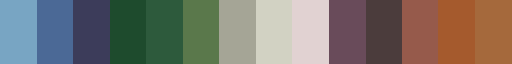

In [8]:
cmap = load_cmap('fleurs_dans_un_vase_de_cristal')
cmap

# Setup data

## Load train data

In [9]:
train_csv = pd.read_csv('data/train.csv')

In [10]:
train_csv.shape

(7478, 33)

Drop rows with all null values, and extreme outliers

In [11]:
train_csv.iloc[[175, 913, 7067, 508, 5789], :]

,Id,Scraped_Time,Condition,Car Make,Model,Trim,Year,Kilometers,Body Type,Number of Seats,...,Neighborhood,Category,Subcategory,Interior Options,Exterior Options,Technology Options,Description_Score,Battery Capacity,Battery Range,Price
175,176,2025-02-07 12:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Khalda,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1750.0
913,914,2025-02-07 12:52:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Russayfah,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
7067,7068,2025-02-07 13:20:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Al Hay Al Sharqy,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1250.0
508,509,2025-02-07 00:50:31,Used,Chevrolet,Cruze,Standard,2010,"80,000 - 89,999",Sedan,5,...,Tla' Ali,Cars and Bikes,Cars For Sale,"AUX / USB Input, Steering Wheel Controls, Elec...","Spare Tyre, Electric Mirrors","Android Auto, Bluetooth, Touch Screen, Media S...",NaN,NaN,NaN,1000000.0
5789,5790,2025-02-06 21:19:43,Used,Toyota,Hiace,Cargo,1991,"130,000 - 139,999",Bus - Van,9,...,Dayr Yusuf,Cars and Bikes,Cars For Sale,Airbags,Back Hook,Navigation system / maps,NaN,NaN,NaN,999999.0


In [12]:
train_csv.drop(index=[175, 913, 7067, 508, 5789], inplace=True)

In [13]:
train_csv.shape

(7473, 33)

## Update Column Names

In [14]:
cols_map = {'Id': 'id', 'Scraped_Time': 'scraped_time', 'Condition': 'condition', 
            'Car Make': 'car_make', 'Model': 'model', 'Trim': 'trim', 'Year': 'year', 
            'Kilometers': 'kilometers', 'Body Type': 'body_type', 'Number of Seats': 'num_of_seats', 
            'Fuel': 'fuel', 'Transmission': 'transmission', 'Engine Size (cc)': 'engine_size_cc', 
            'Exterior Color': 'exterior_color', 'Interior Color': 'interior_color', 
            'Regional Specs': 'regional_specs', 'Car License': 'car_license', 'Insurance': 'insurance', 
            'Car Customs': 'car_customs', 'Body Condition': 'body_condition', 'Paint': 'paint', 
            'Payment Method': 'payment_method', 'City': 'city', 'Neighborhood': 'neighborhood', 
            'Category': 'category', 'Subcategory': 'subcategory', 'Interior Options': 'interior_options', 
            'Exterior Options': 'exterior_options', 'Technology Options': 'technology_options', 
            'Description_Score': 'description_score', 'Battery Capacity': 'battery_capacity', 
            'Battery Range': 'battery_range', 'Price': 'price'}

In [15]:
train_csv.rename(columns=cols_map, inplace=True)
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

## Splitting Train data into Training, Validation and Test sets

In [16]:
target = 'price'
y = train_csv[target]
X = train_csv.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, shuffle=True, test_size=0.15)

In [17]:
print(f'Shape of train set: {X_train.shape, y_train.shape}')
print(f'Shape of val set  : {X_val.shape, y_val.shape}')
print(f'Shape of test set : {X_test.shape, y_test.shape}')

Shape of train set: ((5399, 32), (5399,))
Shape of val set  : ((953, 32), (953,))
Shape of test set : ((1121, 32), (1121,))


# Analyze Outliers in train set

In [18]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.shape

(5399, 33)

### Checking outliers in price

[Text(0.5, 0, ''), Text(0, 0.5, '')]

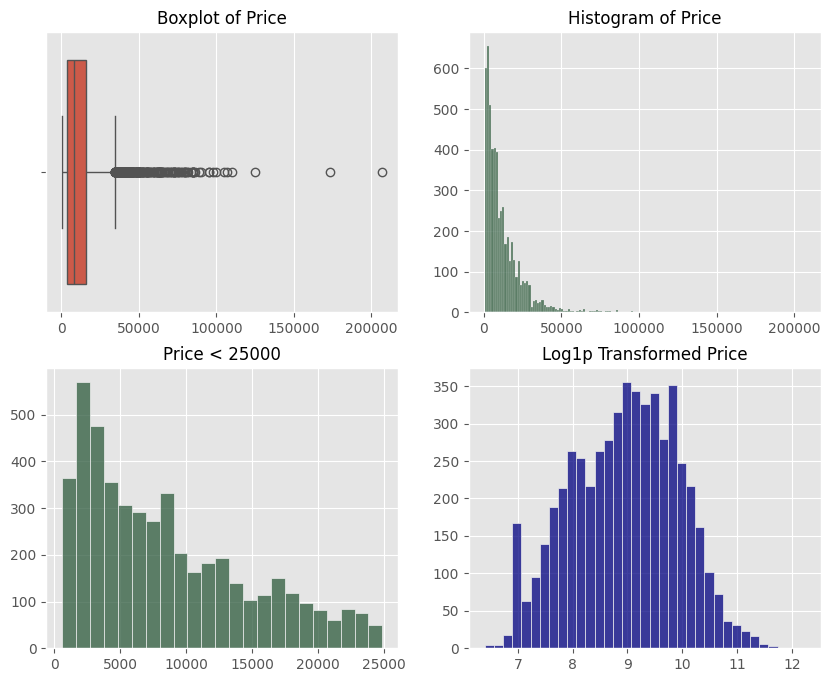

In [19]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.boxplot(data=train_df, x='price', ax=axes[0,0])
axes[0, 0].set_title('Boxplot of Price', fontsize=12)
axes[0, 0].set(xlabel=None, ylabel=None)

sns.histplot(data=train_df, x='price', color='#2D5A3CFF', ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Price', fontsize=12)
axes[0, 1].set(xlabel=None, ylabel=None)

sns.histplot(data=train_df[train_df['price'] < 25000], x='price', color='#2D5A3CFF', ax=axes[1,0])
axes[1, 0].set_title('Price < 25000', fontsize=12)
axes[1, 0].set(xlabel=None, ylabel=None)

log_price = np.log1p(train_df[['price']])
sns.histplot(data=log_price, x='price', color='navy', ax=axes[1, 1])
axes[1, 1].set_title('Log1p Transformed Price', fontsize=12)
axes[1, 1].set(xlabel=None, ylabel=None)

In [20]:
print(f'Price Range of concern: {np.expm1(6.8):.2f}, {np.expm1(7.2):.2f}')
print(f'Price Range of concern: {np.expm1(9.6):.2f}, {np.expm1(10):.2f}')

Price Range of concern: 896.85, 1338.43
Price Range of concern: 14763.78, 22025.47


Both boxplot and histogram show that majority of the data points for 'price' are in the range of (0, 50000). The distribution is heavily right skewed.

In [21]:
skew_value = skew(train_df['price'], bias=True)
print(f'The skewness value for price is {skew_value:.3f}')

The skewness value for price is 3.412


zscore

<Axes: xlabel='price'>

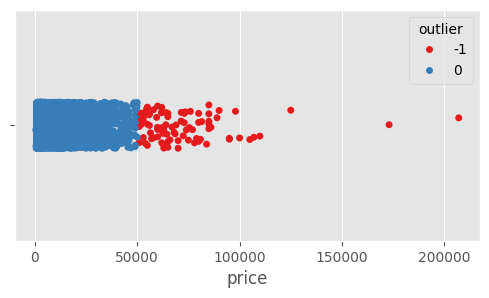

In [22]:
price_df = train_df[['price', 'car_make']].copy()
price_df['zscore'] = zscore(price_df['price'])
price_df['outlier'] = (price_df['zscore'].abs() > 3).map({False:0, True:-1})

plt.figure(figsize=(6, 3))
sns.stripplot(data=price_df, x='price', hue='outlier', orient='h', palette='Set1')

Outlier threshold for price

In [23]:
outliers = price_df[price_df['outlier']==-1]
print(f'There are {len(outliers)} outliers with price above ${outliers['price'].min()}')

There are 93 outliers with price above $50900.0


Distribution of outliers

<Axes: xlabel='price', ylabel='car_make'>

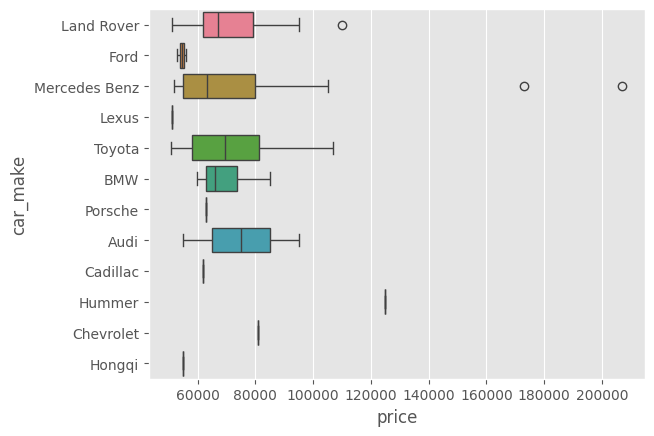

In [24]:
sns.boxplot(data=outliers, x='price', y='car_make', hue='car_make', orient='h')

### Price by Car Makers

<Axes: xlabel='price', ylabel='car_make'>

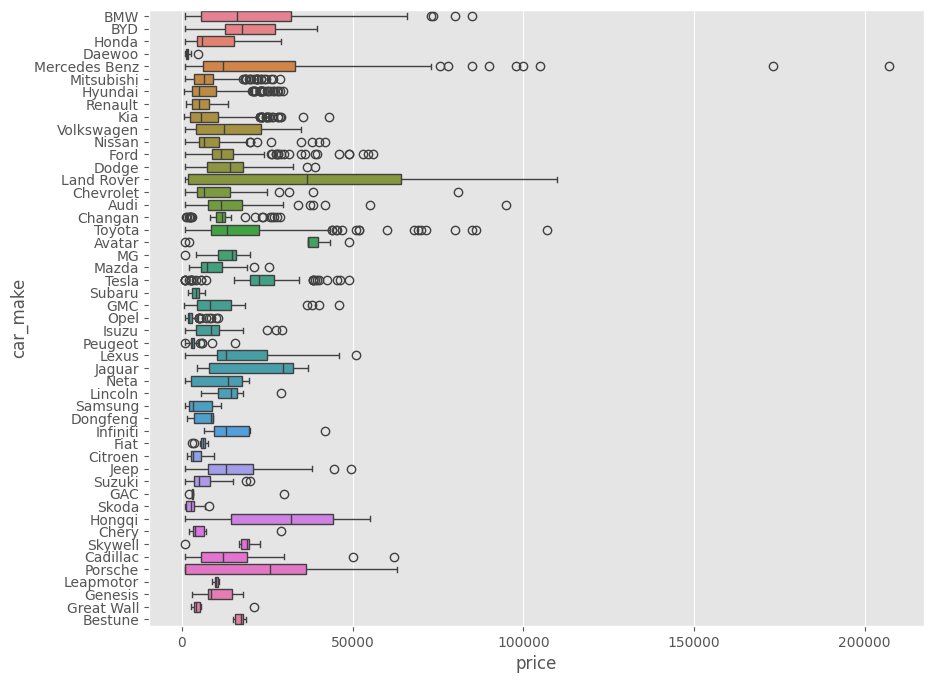

In [25]:
min_count = 5
car_makers_w_min_count = train_df['car_make'].value_counts().reset_index()
car_makers_w_min_count = car_makers_w_min_count[car_makers_w_min_count['count'] > min_count]['car_make']
df = train_df[train_df['car_make'].isin(car_makers_w_min_count)][['car_make', 'price']]
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='price', y='car_make',hue='car_make', orient='h')

For most of the Car Makers, the distribution of price points is narrow which will help in predicting the price with high confidence except few like Porsche, Hongqi, Jaguar, and Land Rover.

For Toyota, Audi, Chevrolet, Mercedes Benz, and BMW, the majority of the price points still fall under a narrow distribution with few outliers - which needs to be studied. My hypothesis is these outliers belong to models in the Sportscar segment. 

### Drill down to Model

<Axes: xlabel='price', ylabel='model'>

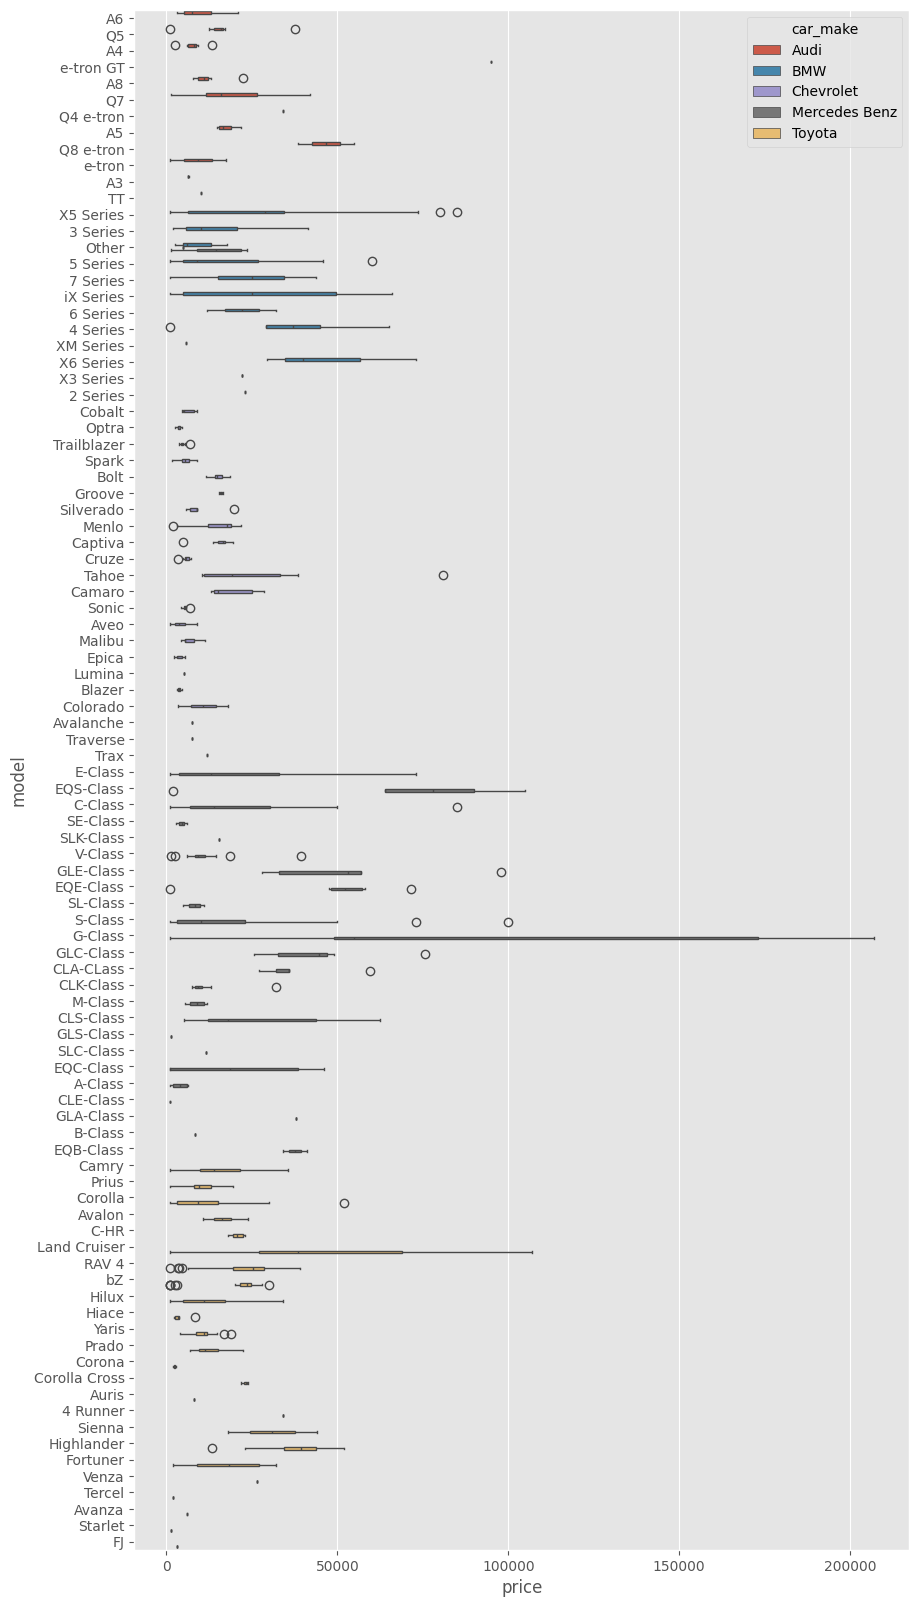

In [26]:
car_makers = ['Toyota', 'Audi', 'Chevrolet', 'Mercedes Benz', 'BMW']
df = train_df[train_df['car_make'].isin(car_makers)][['car_make','model', 'price']]
df.sort_values(by='car_make', inplace=True)
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='price', y='model', hue='car_make', orient='h')

This plot tells us clearly which models have outliers.

Checking few cars with outliers

In [27]:
# train_df[train_df['model']=='Tahoe']
# train_df[train_df['model']=='Land Cruiser'].sort_values(by='price', ascending=False)
train_df[train_df['model']=='G-Class'].sort_values(by='price', ascending=False)

,id,scraped_time,condition,car_make,model,trim,year,kilometers,body_type,num_of_seats,...,neighborhood,category,subcategory,interior_options,exterior_options,technology_options,description_score,battery_capacity,battery_range,price
3064,3065,2025-02-07 13:31:26,New,Mercedes Benz,G-Class,G 500,2021,0,SUV,5,...,Wadi Saqra,Cars and Bikes,Cars For Sale,"Steering Wheel Controls, Memory Seats, CD play...","Spare Tyre, Xenon Lights, Rim Wheels, Panorami...","Blind Spot Alert, Hud Projector, Apple CarPlay...",NaN,NaN,NaN,207000.0
1400,1401,2025-02-07 12:56:08,Used,Mercedes Benz,G-Class,G 500,2020,"30,000 - 39,999",SUV,5,...,Deir Ghbar,Cars and Bikes,Cars For Sale,"Electric Windows, Heated Steering Wheel, Leath...","Back Hook, Sunroof, Xenon Lights, Keyless Entr...","360° Camera, Lane Departure Alert, Blind Spot ...",NaN,NaN,NaN,173000.0
4509,4510,2025-02-07 22:12:08,Used,Mercedes Benz,G-Class,G 550,2010,"+200,000",SUV,5,...,Airport Road - Manaseer Gs,Cars and Bikes,Cars For Sale,"AUX / USB Input, Sport Seats, Electric Seat Co...","Front Sensors, Rear Sensors, Sunroof, Electric...",Android Auto,فحص كامل,NaN,NaN,55000.0
3450,3451,2025-02-07 11:12:33,Used,Mercedes Benz,G-Class,G 500,2009,"+200,000",SUV,5,...,Deir Ghbar,Cars and Bikes,Cars For Sale,"CD player, Leather Seats, AUX / USB Input, Air...","Rear Sensors, Sunroof, Electric Mirrors, Xenon...","Traction Control, Bluetooth, ABS Brakes, Media...",4,NaN,NaN,49000.0
1882,1883,2025-02-06 22:26:56,Used,Mercedes Benz,G-Class,G 63 AMG,2014,"130,000 - 139,999",SUV,5,...,Wadi Saqra,Cars and Bikes,Cars For Sale,"Airbags, Cooled Seats, Electric Seat Control, ...","Electrically Folding Mirrors, Daytime Running ...","Media Screen, ABS Brakes, Rear Camera, Tractio...",NaN,NaN,NaN,1000.0


id - 5732 - New, 0 km - $1000 - seems incorrect

There seem to be lot of such errors/outliers across combination of all features.

Rows with price as $1000 may be an issue.

## Luxury Cars

In [28]:
y_train_binned = pd.qcut(y_train, q=30, duplicates='drop')
y_train_binned.unique()

[(3800.0, 4400.0], (17000.0, 18500.0], (18500.0, 20500.0], (1650.0, 2000.0], (12683.333, 13800.0], ..., (9500.0, 10580.0], (7500.0, 8000.0], (6200.0, 6800.0], (39513.333, 207000.0], (2700.0, 3000.0]]
Length: 30
Categories (30, interval[float64, right]): [(599.999, 1000.0] < (1000.0, 1650.0] < (1650.0, 2000.0] < (2000.0, 2400.0] ... (23000.0, 26500.0] < (26500.0, 29600.0] < (29600.0, 39513.333] < (39513.333, 207000.0]]

The top quantile is (26500.0, 207000.0]

In [29]:
luxury_pairs = (
    train_df[train_df['price'] > 50000]
    .groupby(['car_make', 'model'])
    .agg({'price':['count', 'median']})
    .reset_index()
    .sort_values(by=('price','median'), ascending=False)
    )
luxury_set = set(zip(luxury_pairs['car_make'], luxury_pairs['model']))

## Preprocessor

In [30]:
drop_features = ['id', 'scraped_time', 'category', 'subcategory', 'description_score']
options_features = ['interior_options', 'exterior_options', 'technology_options']
cat_features_imp_zero = ['trim', 'neighborhood']
cat_features_imp_freq = ['condition', 'car_make', 'model', 
                         'body_type', 'num_of_seats', 'fuel', 'transmission', 
                         'exterior_color', 'interior_color', 'regional_specs', 
                         'car_license', 'insurance', 'car_customs', 'body_condition', 'paint', 
                         'payment_method', 'city']

In [31]:
len(drop_features + options_features + cat_features_imp_freq + cat_features_imp_zero)

27

In [32]:
cat_impute_freq_pipeline = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_to_str', FunctionTransformer(convert_to_str)),
    ('freq_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=5))
])

In [33]:
cat_impute_zero_pipeline = Pipeline(steps=[
    ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('zero_to_str', FunctionTransformer(convert_to_str)),
    ('zero_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=5))
])

In [34]:
preprocessor = ColumnTransformer(transformers=[
    ('cat_impute_freq', cat_impute_freq_pipeline, cat_features_imp_freq),
    ('cat_impute_zero', cat_impute_zero_pipeline, cat_features_imp_zero),
    ('engine_size', Pipeline([
        ('engine_transform', EngineSizeTransformer()),
        ('scaler', StandardScaler())
    ]), ['engine_size_cc']),

    ('year', Pipeline([
        ('year_transform', YearTransformer()),
        ('scaler', StandardScaler())
    ]), ['year']),

    ('km', Pipeline([
        ('km_transform', KilometersTransformer()),
        ('scaler', StandardScaler())
    ]), ['kilometers']),

    ('battery_cap', Pipeline([
        ('battery_cap_transform', BatteryCapacityTransformer()),
        ('scaler', StandardScaler())
    ]), ['battery_capacity']),

    ('battery_range', Pipeline([
        ('battery_range_transform', BatteryRangeTransformer()),
        ('scaler', StandardScaler())
    ]), ['battery_range']),
    
    ('multi_options', MultiLabelBinarizerTransformer(columns=options_features), options_features),
    ('luxury_flag', LuxuryCarFlagger(luxury_set=luxury_set), ['car_make', 'model']),
    ('drop', 'drop', drop_features)
], remainder='passthrough')

In [35]:
train_df_transformed = preprocessor.fit_transform(train_df)
train_df_transformed.shape

(5399, 710)

In [36]:
train_trf_array = train_df_transformed.toarray()
sparsity = np.sum(train_trf_array == 0) / train_trf_array.size
print(f'The sparsity of the preprocessed train df is {sparsity:.2f}')

The sparsity of the preprocessed train df is 0.94


## Outliers using Isolation Forest

In [37]:
# iso = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
# outlier_preds = iso.fit_predict(train_trf_array)
# np.unique(outlier_preds)

## Outliers using  Local Outlier Factor (LOF)

In [38]:
lof = LocalOutlierFactor(n_neighbors=40, contamination='auto', n_jobs=-1)
outlier_preds = lof.fit_predict(train_trf_array)
print(np.unique(outlier_preds))
print(np.bincount(outlier_preds+1))

[-1  1]
[ 839    0 4560]


In [39]:
train_df['outlier'] = outlier_preds

## Visualizing Outliers

Price by Car Maker

<Axes: xlabel='price', ylabel='car_make'>

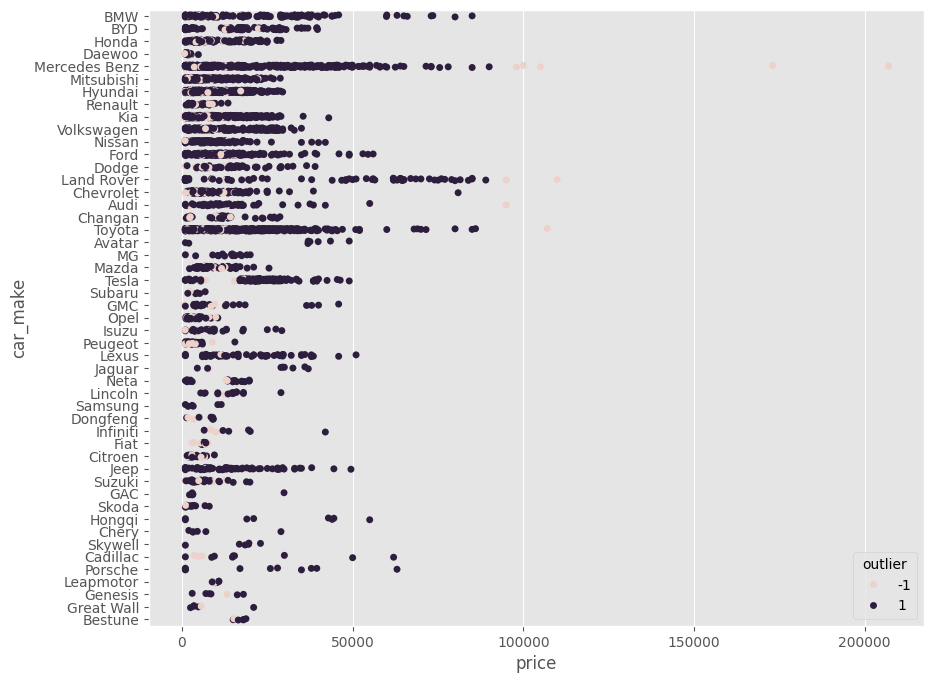

In [40]:
df = train_df[train_df['car_make'].isin(car_makers_w_min_count)][['car_make', 'model', 'price', 'outlier']]
plt.figure(figsize=(10,8))
sns.stripplot(data=df, x='price', y='car_make', hue='outlier', orient='h')

<Axes: xlabel='price', ylabel='maker_model'>

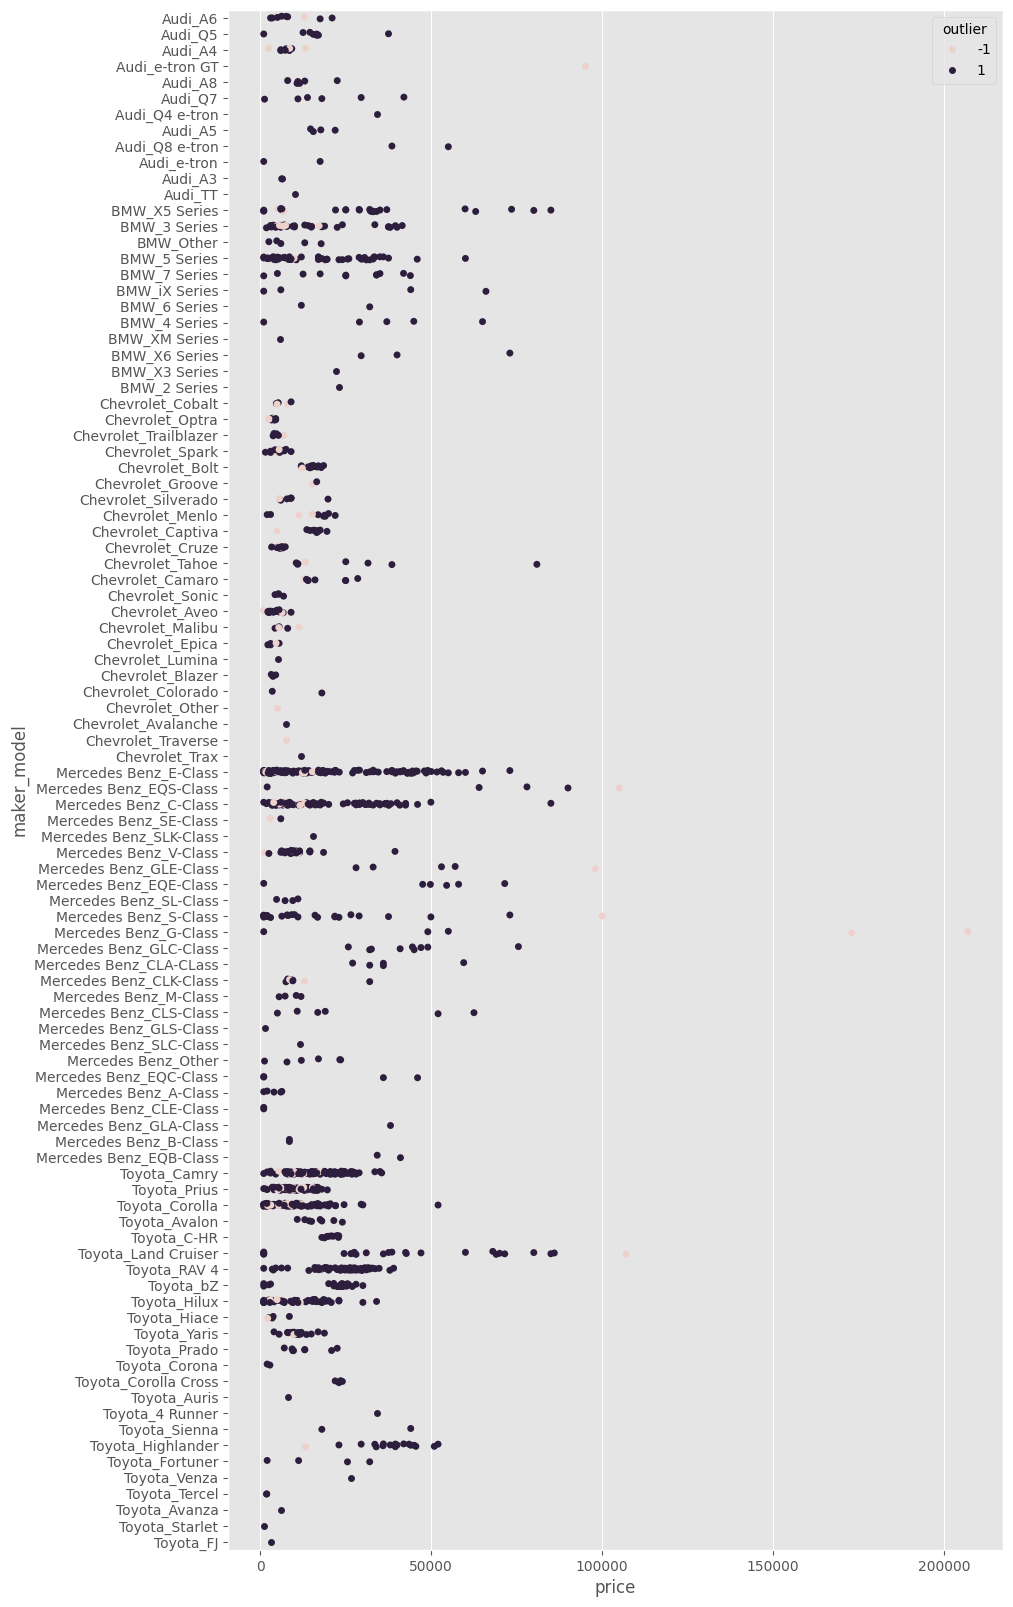

In [41]:
car_makers = ['Toyota', 'Audi', 'Chevrolet', 'Mercedes Benz', 'BMW']
df = train_df[train_df['car_make'].isin(car_makers)][['car_make', 'model', 'price', 'outlier']]
df['maker_model'] = df['car_make'] + '_' + df['model']
df.sort_values(by='car_make', inplace=True)
plt.figure(figsize=(10, 20))
sns.stripplot(data=df, x='price', y='maker_model', hue='outlier', orient='h')

# Removing Identified Outliers

In [42]:
# train_df_2 = train_df[train_df['outlier'] == 1].copy()
# y_train = train_df_2['price']
# X_train = train_df_2.drop(columns=['price', 'outlier'])

# Including Outliers

In [43]:
y_train = train_df['price']
X_train = train_df.drop(columns=['price', 'outlier'])

Text(0.5, 1.0, 'Training Set - Price')

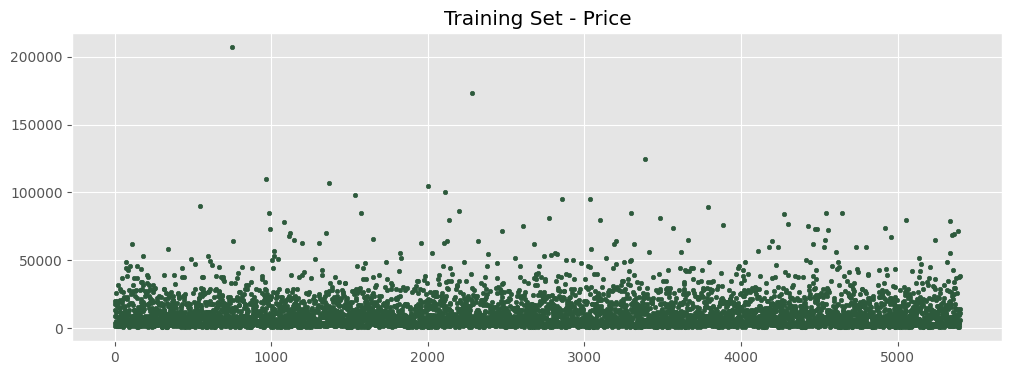

In [44]:
plt.figure(figsize=(12, 4))
plt.scatter(x=range(len(y_train)), y=y_train, marker='o', c='#2D5A3CFF', s=10)
plt.title('Training Set - Price')

# Function - Get Feature Names from Model

In [45]:
def get_feature_names_preprocessor(preprocessor):
    output_features = []

    for name, trf, cols in preprocessor.transformers_:
        if trf == 'drop':
            continue
        elif trf == 'passthrough':
            output_features.extend(cols)
        else:
            if hasattr(trf, 'named_steps'):
                last_step = trf.named_steps[list(trf.named_steps)[-1]]
            else:
                last_step = trf
        
        if hasattr(last_step, 'get_feature_names_out'):
            transformed_names = last_step.get_feature_names_out(cols)
        else:
            transformed_names = cols
        
        output_features.extend(transformed_names)
    
    return output_features

In [61]:
def get_feature_names_model(model):
    feature_names = get_feature_names_preprocessor(model.named_steps['preprocessor'])
    if 'poly' in list(model.named_steps):
        feature_names = model.named_steps['poly'].get_feature_names_out(feature_names)
    return feature_names

# Train Test RMSE function

In [47]:
def get_train_test_rmse(model):
    train_rmse = root_mean_squared_error(y_train, model.predict(X_train))
    val_rmse = root_mean_squared_error(y_val, model.predict(X_val))

    print(f'Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}')

## Important Features

In [48]:
def feature_importance_plot(model, regressor_name, top_pos_features, top_neg_features=None):
    feature_names = get_feature_names_model(model)

    imp_coef = model.named_steps[regressor_name].feature_importances_
    idx_sorted_imp_coef = np.argsort(imp_coef)[::-1]

    if top_neg_features != None:
        top_idxs = np.append(idx_sorted_imp_coef[:top_pos_features], idx_sorted_imp_coef[-top_neg_features:])
        total = top_pos_features + top_neg_features
    else:
        top_idxs = idx_sorted_imp_coef[:top_pos_features]
        total = top_pos_features
    
    top_features = [feature_names[i] for i in top_idxs]
    top_features_coef = [imp_coef[i] for i in top_idxs]

    plt.figure(figsize=(12, 6))
    plt.style.use('ggplot')
    plt.barh(top_features, top_features_coef)
    plt.ylabel('Features')
    plt.yticks(size=8)
    plt.xlabel('Importance')
    plt.title(f'Top {total} Features by Importance')
    plt.tight_layout()

# Weighted Training

In [49]:
price_bins = pd.qcut(y_train, q=20, duplicates='drop')

bin_counts = price_bins.value_counts()
print(bin_counts.reset_index().sort_values('price'))
weights = 1 / bin_counts.reindex(price_bins).values
weights.shape

                  price  count
8     (599.999, 1400.0]    271
0      (1400.0, 2000.0]    330
16     (2000.0, 2500.0]    255
4      (2500.0, 3000.0]    276
19     (3000.0, 3600.0]    235
15     (3600.0, 4400.0]    260
13     (4400.0, 5250.0]    264
3      (5250.0, 6200.0]    278
14     (6200.0, 7100.0]    263
11     (7100.0, 8000.0]    268
6      (8000.0, 9100.0]    274
12    (9100.0, 10580.0]    265
9    (10580.0, 12070.0]    270
5    (12070.0, 13800.0]    276
7    (13800.0, 16000.0]    273
2    (16000.0, 18500.0]    279
18   (18500.0, 21865.0]    252
1    (21865.0, 26500.0]    285
17   (26500.0, 34525.0]    255
10  (34525.0, 207000.0]    270


(5399,)

# MLP

In [86]:
# without applying log1p on target
mlp_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('poly', PolynomialFeatures(degree=2)),
    ('mlp', MLPRegressor(hidden_layer_sizes=[60, 60], random_state=42, activation='relu'))
], memory=memory)

mlp_pipe.fit(X_train, y_train)

c:\Users\akuka\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(memory=Memory(location=cache_dir\joblib),
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function convert_to_str at 0x000001AD76BF6480>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unkno...
                                                                                'Benz',
                                                                                'E-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'EQE-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'EQS-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'G-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'GLC-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'GLE-Class'), ...}),
                                                  ['car_make', 'model']),
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=[60, 60], random_state=42))])

#4 lgbm dart - without log transforming target

Best params: {'lgbm__learning_rate': 0.1, 'lgbm__max_bin': 255, 'lgbm__max_depth': 15, 'lgbm__num_leaves': 50}

Best score: -8525.009

Val score - 8188.88

Score on Validation Set

In [87]:
get_train_test_rmse(mlp_pipe)

Train RMSE: 7275.411, Val RMSE: 8383.836


Text(0.5, 1.0, 'Actual vs Prediction Histogram')

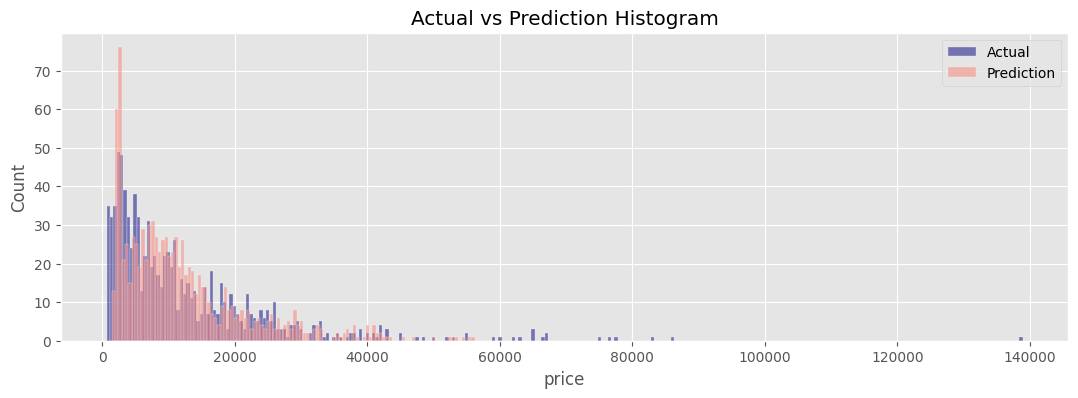

In [88]:
y_pred_val = mlp_pipe.predict(X_val)

plt.figure(figsize=(13, 4))
sns.histplot(x=y_val, label='Actual', alpha=0.5, color='navy', binwidth=500)
sns.histplot(x=y_pred_val, label='Prediction', alpha=0.5, color='salmon', binwidth=500)

# sns.histplot(x=y_val, label='Actual', alpha=0.5, color='navy', log_scale=True)
# sns.histplot(x=y_pred_val, label='Prediction', alpha=0.5, color='salmon', log_scale=True)

plt.legend()
# plt.xlim(-1, 20000)
# plt.ylim(-1, 40000)
plt.title('Actual vs Prediction Histogram')

Text(0.5, 1.0, 'Actual vs Prediction Histogram - Zoomed')

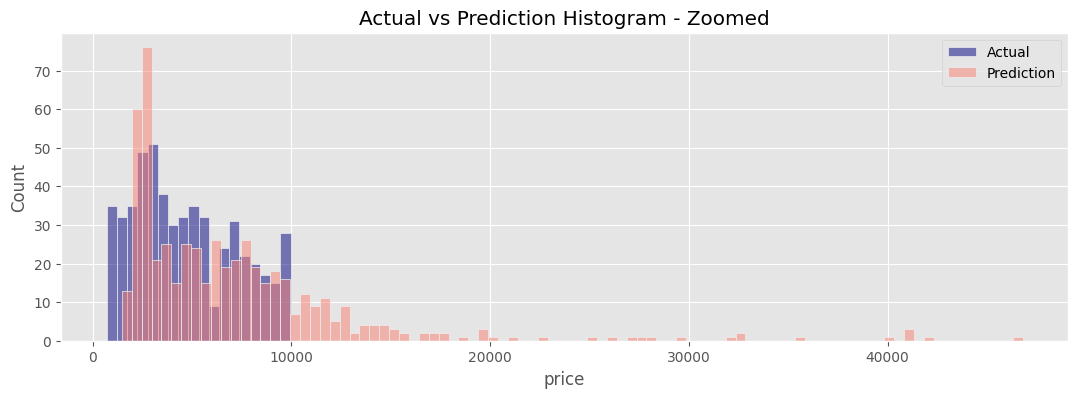

In [89]:
low_cap = 0
up_cap = 10000
X_val_zoom = X_val[(y_val > low_cap) & (y_val < up_cap)]
y_val_zoom = y_val[(y_val > low_cap) & (y_val < up_cap)]
y_val_zoom_pred = mlp_pipe.predict(X_val_zoom)

plt.figure(figsize=(13, 4))
sns.histplot(x=y_val_zoom, label='Actual', alpha=0.5, color='navy', binwidth=500)
sns.histplot(x=y_val_zoom_pred, label='Prediction', alpha=0.5, color='salmon', binwidth=500)

# sns.histplot(x=y_val, label='Actual', alpha=0.5, color='navy', log_scale=True)
# sns.histplot(x=y_pred_val, label='Prediction', alpha=0.5, color='salmon', log_scale=True)

plt.legend()
# plt.xlim(-1, 20000)
# plt.ylim(-1, 40000)
plt.title('Actual vs Prediction Histogram - Zoomed')

## Check Model Performance in different price ranges

In [90]:
range_width = 10000
total_samples = 0
for up_cap in range(range_width, 140000, range_width):
    low_cap = up_cap - range_width
    mask = (y_val > low_cap) & (y_val < up_cap)
    
    if np.sum(mask) == 0:
        continue

    X_val_range = X_val[mask]
    y_val_range = y_val[mask]
    samples_in_range = len(X_val_range)
    total_samples += samples_in_range
    y_pred_range = mlp_pipe.predict(X_val_range)
    rmse = root_mean_squared_error(y_val_range, y_pred_range)

    print(f'{low_cap}-{up_cap} ({samples_in_range}): {rmse:.2f}')
print(f'Total samples: {total_samples}')

0-10000 (535): 7015.90
10000-20000 (234): 4501.29
20000-30000 (106): 6220.93
30000-40000 (26): 10111.22
40000-50000 (14): 14499.48
50000-60000 (5): 23063.64
60000-70000 (8): 24371.71
70000-80000 (3): 33838.95
80000-90000 (2): 46371.35
Total samples: 933


# Prediction on Test

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.15)
mlp_pipe.fit(X_train, y_train)

c:\Users\akuka\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(memory=Memory(location=cache_dir\joblib),
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function convert_to_str at 0x000001AD76BF6480>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unkno...
                                                                                'Benz',
                                                                                'E-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'EQE-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'EQS-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'G-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'GLC-Class'),
                                                                               ('Mercedes '
                                                                                'Benz',
                                                                                'GLE-Class'), ...}),
                                                  ['car_make', 'model']),
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=[60, 60], random_state=42))])

In [92]:
y_pred_test = mlp_pipe.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

In [93]:
print(f'RMSE on unseen test data: {test_rmse:.2f}')

RMSE on unseen test data: 8387.27
